## 1. Error analysis for nbs from github - the stack v1

https://huggingface.co/datasets/bigcode/the-stack-dedup/tree/main/data/jupyter-notebook


In [2]:
# read in all errors from the file
import pandas as pd

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3.csv', encoding='utf-8')
df2_err = df2_err[df2_err['language']=='python'][['fname','ename','evalue','traceback']]
df2_err.head()

,fname,ename,evalue,traceback
0,00000-101-cookie-clicker-v2-checkpoint.ipynb,KeyboardInterrupt,NaN,['--------------------------------------------...
1,00000-1012-demand-forecasting-data-prep-from-s...,OperationalError,"FATAL: no pg_hba.conf entry for host ""75.166....",['--------------------------------------------...
2,00000-1017-heatmapseq2seq.ipynb,ValueError,"x and y must have same first dimension, but ha...",['--------------------------------------------...
3,00000-1023-crawler-20190515-20190516.ipynb,ConnectionError,HTTPSConnectionPool(host='www.backpackers.com....,['--------------------------------------------...
4,00000-1033-peer-solution-predicting-survival-t...,URLError,<urlopen error [Errno 11001] getaddrinfo failed>,['--------------------------------------------...


In [3]:
df2_err.count()

fname        177540
ename        177396
evalue       158707
traceback    177540
dtype: int64

In [6]:
df2_err["fname"].nunique()

109063

In [5]:
df2_err["ename"].nunique()

1520

<Axes: xlabel='ename'>

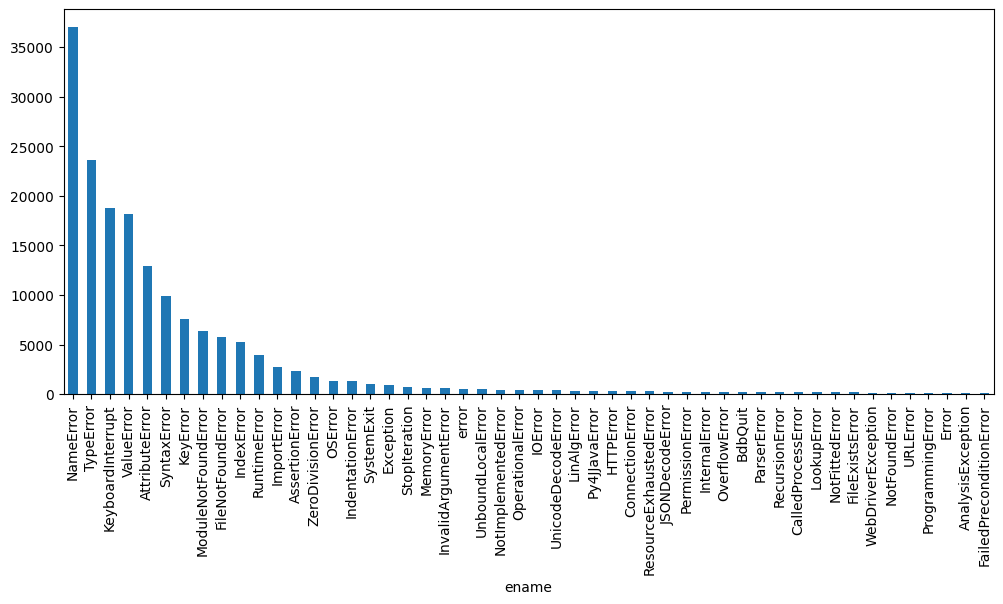

In [7]:
df2_err["ename"].groupby([df2_err["ename"]]).count().sort_values(ascending=0)[:50].plot(kind="bar", figsize=(12,5))

<Axes: xlabel='ename'>

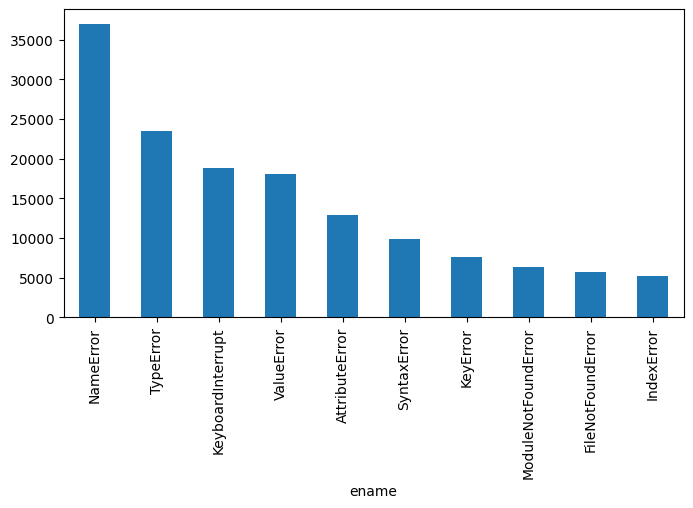

In [8]:
df2_err["ename"].groupby([df2_err["ename"]]).count().sort_values(ascending=0)[:10].plot(kind="bar", figsize=(8,4))

### 1.1 Clustering with K-Means

In [4]:
import pandas as pd 
import cluster_util

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3.csv', encoding='utf-8')
df2_err = df2_err[df2_err['language']=='python'][['fname','ename','evalue','traceback']]

#### preprocess - tokenize

In [ ]:
#!python -m spacy download en_core_web_trf

In [3]:
import spacy

nlp = spacy.load('en_core_web_trf')
df2_err['evalue_tokenized'] = df2_err['evalue'].apply(cluster_util.preprocess_text, nlp=nlp)

In [11]:
df2_err.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evaluetokenized.csv", index=False, encoding='utf-8')

#### !!! Clustering start here ---> load tokenized error dataset

In [1]:
import pandas as pd 
import cluster_util

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3_evaluetokenized.csv', encoding='utf-8')
df2_err = df2_err[['ename','evalue','evalue_tokenized']]

#### 1.1.1 ValueError, evalue_tokenized

In [2]:
df2_err_ename = df2_err[df2_err['ename']=='ValueError']
err_descs = df2_err_ename['evalue_tokenized'].values.astype('U')

##### tfidf

In [3]:
X_tfidf = cluster_util.vectorizer_tfidf(err_descs)
X_tfidf.shape

In [5]:
K_range = range(1,15)
inertias = cluster_util.elbow_for_kmean(X_tfidf, K_range = K_range)

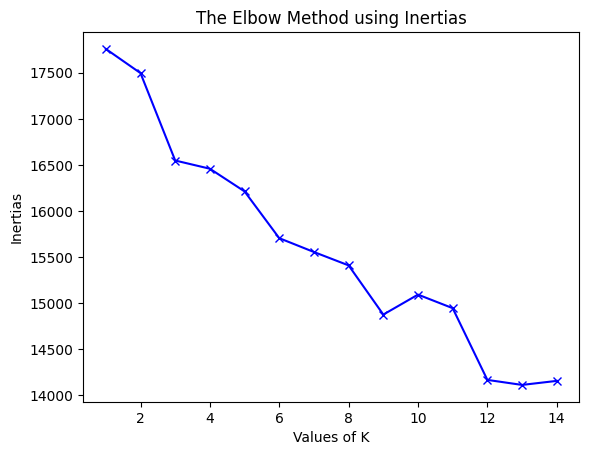

In [8]:
plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [22]:
num_clusters = 12
res = cluster_util.cluster_kmeans(X_tfidf, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 962 samples
                                                   evalue  cluster
131596   invalid literal for long() with base 10: 'hello'        0
173148    invalid literal for int() with base 10: 'hello'        0
91978         invalid literal for int() with base 10: 'a'        0
135934     invalid literal for int() with base 10: 'abcd'        0
20861   invalid literal for int() with base 10: 'Date,...        0
90042       invalid literal for int() with base 10: '7.4'        0
24129     invalid literal for int() with base 10: 'hello'        0
26359   invalid literal for int() with base 10: 'TCGA-...        0
154185  invalid literal for int() with base 10: '#Stag...        0
114596         invalid literal for int() with base 10: ''        0


cluster 1 has 716 samples
                                                   evalue  cluster
46825              too many values to unpack (expected 1)        1
49500   not enough values to unpack (expected 13, got 12)        1
59845   

In [26]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_tfidf"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

##### sentence transformers

https://github.com/UKPLab/sentence-transformers

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentence to vector

In [4]:
import pandas as pd 
import cluster_util

df2_err_ename = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv', encoding='utf-8')
err_descs = df2_err_ename['evalue_tokenized'].values.astype('U')

In [9]:
X_transformers = cluster_util.vectorizer_sentence2vec(err_descs)
X_transformers.shape

(18148, 384)

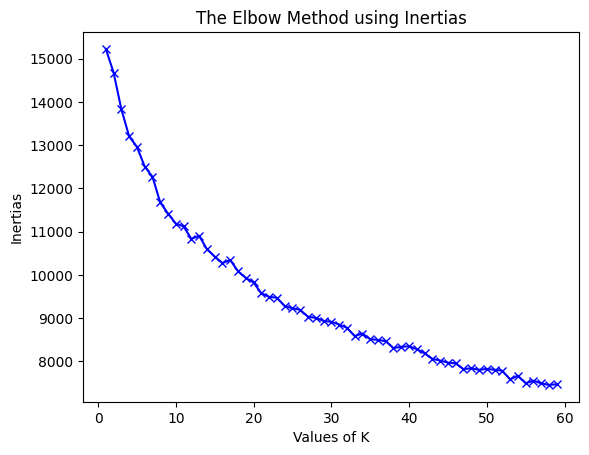

In [17]:
K_range = range(1,60)
inertias = cluster_util.elbow_for_kmean(X_transformers, K_range = K_range)

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [13]:
num_clusters = 12
res = cluster_util.cluster_kmeans(X_transformers, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 976 samples
                                                 evalue  cluster
17516   invalid literal for int() with base 10: 'Hello'        0
188      invalid literal for int() with base 10: '98.6'        0
9347      invalid literal for int() with base 10: 'six'        0
1534    invalid literal for int() with base 10: 'hello'        0
9088      invalid literal for int() with base 10: '10p'        0
3632     invalid literal for int() with base 10: '12.5'        0
12321       invalid literal for int() with base 10: 'C'        0
990     invalid literal for int() with base 10: 'hello'        0
4692         invalid literal for int() with base 10: ''        0
7892   invalid literal for long() with base 10: 'hello'        0


cluster 1 has 706 samples
                                                  evalue  cluster
541    Pandas data cast to numpy dtype of object. Che...        1
5858   Input contains NaN, infinity or a value too la...        1
2935   Input contains NaN, infini

In [21]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_transformers"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

##### word embeddings - GloVe

Turn sentences to vectors via word embeddings by taking the mean/sum of all word embeddings of the sentence

In [48]:
glove_vectors = cluster_util.load_glove("C:/Users/yirwa29/Downloads/Dataset-Nb/glove.6B/glove.6B.200d.txt")
X_glove = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])

In [49]:
X_glove.shape

(18148, 200)

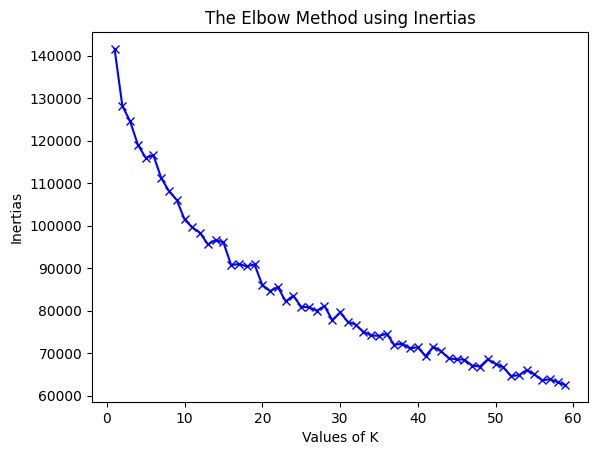

In [50]:
K_range = range(1,60)
inertias = cluster_util.elbow_for_kmean(X_glove, K_range = K_range)

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [51]:
num_clusters = 12
res = cluster_util.cluster_kmeans(X_glove, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 995 samples
                                                  evalue  cluster
16754  invalid literal for int() with base 10: '0.752...        0
11005    invalid literal for long() with base 10: 'hola'        0
14279  invalid literal for int() with base 10: '5,000...        0
15671       invalid literal for int() with base 10: '5a'        0
15183        invalid literal for int() with base 10: 'a'        0
8239                             cannot convert k to int        0
9088       invalid literal for int() with base 10: '10p'        0
4878     invalid literal for int() with base 10: 'teste'        0
8942       invalid literal for int() with base 10: 'inf'        0
17457     invalid literal for int() with base 10: '13A2'        0


cluster 1 has 3375 samples
                                                  evalue  cluster
8385   Unable to coerce to Series, length must be 1: ...        1
12050                       Value must be a real number.        1
8724         3 column

In [53]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_glove"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

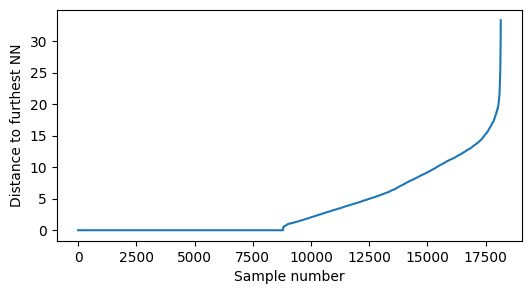

In [103]:
X_glove_scaled = cluster_util.scaling(X_glove)
cluster_util.eps_dbscan(n_neighbors, X_glove_scaled)

In [113]:
res = cluster_util.cluster_dbscan(X_glove_scaled, eps=5, min_samples=10)

Estimated no. of clusters: 198
Estimated no. of noise points: 7398


In [22]:
num_clusters = 8
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=1000)
# plot the results 
# cluster_util.plot_clusters(vectorized_descs, num_clusters, km_model.labels_)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 716 samples
                                               errdesc  cluster
17556           too many values to unpack (expected 4)        0
17832           too many values to unpack (expected 2)        0
2238            too many values to unpack (expected 2)        0
1883            too many values to unpack (expected 4)        0
9730   not enough values to unpack (expected 5, got 1)        0
8018            too many values to unpack (expected 2)        0
5165   not enough values to unpack (expected 3, got 1)        0
17923           too many values to unpack (expected 2)        0
179             too many values to unpack (expected 2)        0
6100                     All values must >= 1 and <= 9        0


cluster 1 has 965 samples
                                                 errdesc  cluster
1171      invalid literal for int() with base 10: 'Good'        1
12451        invalid literal for int() with base 10: ' '        1
11841  invalid literal for int() with base 1

##### Note:

8 clusters for ValueError:

    1. too many values to unpack
    2. invalid literal for int() with base 10
    3. setting an array element with a sequence, The truth value of a Series is ambiguous/with more than one value..
    4. others
    5. operands could not be broadcast together ...
    6. Input contains NaN, infinity or..
    7. array shape mismatch
    8. could not convert *sometype* to *sometype* ..

#### NameError, evalue

In [6]:
df2_err_ename = df2_err[df2_err['ename']=='NameError']
err_descs = df2_err_ename['evalue'].values.astype('U') # traceback: memory error

In [ ]:
num_clusters = 2
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters) # km_model, res, vectorized_descs
# plot the results 
# cluster_util.plot_clusters(vectorized_descs, num_clusters, km_model.labels_)

In [7]:
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 50 samples
                              errdesc  cluster
36857     name 'error' is not defined        0
30187     name 'error' is not defined        0
166       name 'error' is not defined        0
17326     name 'error' is not defined        0
694       name 'error' is not defined        0
1979      name 'error' is not defined        0
32475     name 'error' is not defined        0
34312     name 'error' is not defined        0
31205  This is the raised name error.        0
25804     name 'error' is not defined        0


cluster 1 has 36955 samples
                                   errdesc  cluster
7019              name 'df' is not defined        1
31697           name 'tmax' is not defined        1
20632            name 'nlp' is not defined        1
10551             name 'np' is not defined        1
35938             name 'bb' is not defined        1
11316          name 'model' is not defined        1
23866           name 'set1' is not defined        1
5088        

##### Note:

found **ignored** values in evalue column in a cluster, but they seem have evalue in traceback. I extracted those and retried.

##### No obvious clusters found in NameError.

#### TypeError, evalue

In [16]:
df2_err_ename = df2_err[df2_err['ename']=='TypeError']
err_descs = df2_err_ename['evalue'].values.astype('U') # traceback: memory error

In [17]:
num_clusters = 10
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=1000)
# plot the results 
# cluster_util.plot_clusters(vectorized_descs, num_clusters, km_model.labels_)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 1488 samples
                                             errdesc  cluster
11659    can only concatenate str (not "int") to str        0
8625                    'int' object is not iterable        0
4428                    'str' object is not callable        0
12026    can only concatenate str (not "int") to str        0
21289    can only concatenate str (not "int") to str        0
6557           cannot unpack non-iterable int object        0
14131                   'str' object is not callable        0
9622                            must be str, not int        0
9063     can only concatenate str (not "int") to str        0
16412  can only concatenate str (not "float") to str        0


cluster 1 has 2519 samples
                                                 errdesc  cluster
18588  emptyFunction() takes 0 positional arguments b...        1
20039  field() takes 0 positional arguments but 1 was...        1
1419   emptyFunction() takes 0 positional arguments b...        

##### Note:

10 clusters for TypeError:

    1. can only concatenate *something* to str
    2. *something* missing *somenumber* required positional arguments...
    3. *something* object is not callable/iterable/has no len()
    4. *something* object does not support item assignment
    5. others
    6. list/tuple indices must be integers or slices, not str
    7. unhashable type: 'list/dict/slice', can only concatenate list (not "int") to list
    8. unsupported operand type(s) for -: 'str' and '..
    9. *something* object cannot be interpreted/converted...
    10. '<' not supported between instances of 'str' a..

#### AttributeError, evalue

In [23]:
df2_err_ename = df2_err[df2_err['ename']=='AttributeError']
err_descs = df2_err_ename['evalue'].values.astype('U')

In [24]:
num_clusters = 2
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=500)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 855 samples
                                                 errdesc  cluster
12354         'DataFrame' object has no attribute 'Date'        0
2388           'DataFrame' object has no attribute 'get'        0
11488     'DataFrame' object has no attribute 'pred_sgd'        0
5408            'DataFrame' object has no attribute 'ix'        0
2060        'DataFrame' object has no attribute 'unique'        0
12927          'DataFrame' object has no attribute 'str'        0
1511          'DataFrame' object has no attribute 'prob'        0
1765   'DataFrame' object has no attribute 'fivegram_...        0
5366           'DataFrame' object has no attribute 'hit'        0
12886       'DataFrame' object has no attribute 'equity'        0


cluster 1 has 12076 samples
                                                 errdesc  cluster
6759           'Person' object has no attribute '__name'        1
7564         module 'numpy' has no attribute 'heaviside'        1
4495                

##### Note: No obvious clusters in AttributeError

#### SyntaxError, evalue

In [25]:
df2_err_ename = df2_err[df2_err['ename']=='SyntaxError']
err_descs = df2_err_ename['evalue'].values.astype('U')

In [27]:
num_clusters = 10
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=500)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 77 samples
                                                errdesc  cluster
9201  keyword can't be an expression (<ipython-input...        0
7244  f-string expression part cannot include a back...        0
2900  keyword can't be an expression (<ipython-input...        0
6632  keyword can't be an expression (<ipython-input...        0
2495  keyword can't be an expression (<ipython-input...        0
7260  can't use starred expression here (<ipython-in...        0
6006  keyword can't be an expression (<ipython-input...        0
7055  can't use starred expression here (<ipython-in...        0
1262  keyword can't be an expression (<ipython-input...        0
461   keyword can't be an expression (<ipython-input...        0


cluster 1 has 58 samples
                                                errdesc  cluster
8337  invalid syntax (<ipython-input-35-fba0d58980c0...        1
7267  'return' outside function (<ipython-input-8-6e...        1
951   invalid syntax (<ipython-input-3

#### Some mixed error types, evalue

In [28]:
df2_err_ename = df2_err[df2_err['ename'].isin(['Error', 'ERROR', 'error'])]
err_descs = df2_err_ename['evalue'].values.astype('U')

In [35]:
num_clusters = 7
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=800)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 220 samples
                                                errdesc  cluster
121   Error in eval(expr, envir, enclos): objet 'hqw...        0
1719  Error in eval(expr, envir, enclos): object 're...        0
1859                                      compile_error        0
1401  Error in eval(expr, envir, enclos): wrong resu...        0
881                                       compile_error        0
1320  Error in eval(expr, envir, enclos): object 'wm...        0
2120  Error in get(name, envir = envir): object 's_l...        0
676   Error in eval(expr, envir, enclos): object 'me...        0
1627  Error in eval(expr, envir, enclos): object '.....        0
2083  Error in eval(expr, envir, enclos): Objekt 'nu...        0


cluster 1 has 140 samples
                                                errdesc  cluster
123   Error in library("scHOT"): there is no package...        1
1063  Error in library(prophet): there is no package...        1
33    Error in library(mxnet): there

## 2. Error analysis for nbs from kaggle


In [1]:
# read in all errors from the file
import pandas as pd

path_err = 'C:/Users/yirwa29/Downloads/Dataset-Nb/nbdata_k_error/nberror_k.csv'
df_err = pd.read_csv(path_err, encoding='utf-8')